In [1]:
import os


def warn(*args, **kwargs):
    pass


import warnings

warnings.warn = warn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern, WhiteKernel

In [13]:
folders = ['vm/same/3high-3low/0iid', 'vm/same/3high-3low/100iid',
           'vm/same/5high-5low/0iid', 'vm/same/5high-5low/100iid',
           'vm/same/10high-10low/0iid', 'vm/same/10high-10low/100iid',
           'vm/same/4high-2low/0iid', 'vm/same/4high-2low/100iid',
           'vm/same/8high-4low/0iid', 'vm/same/8high-4low/100iid',
           'vm/same/2high-4low/0iid', 'vm/same/2high-4low/100iid',
           'vm/same/4high-8low/0iid', 'vm/same/4high-8low/100iid',
           'vm/same/2high-8low/0iid', 'vm/same/2high-8low/100iid',
           'vm/new/3high-3low/0iid', 'vm/new/3high-3low/100iid',
           'vm/new/5high-5low/0iid', 'vm/new/5high-5low/100iid',
           'vm/new/10high-10low/0iid', 'vm/new/10high-10low/100iid',
           'vm/new/4high-2low/0iid', 'vm/new/4high-2low/100iid',
           'vm/new/8high-4low/0iid', 'vm/new/8high-4low/100iid',
           'vm/new/2high-4low/0iid', 'vm/new/2high-4low/100iid',
           'vm/new/4high-8low/0iid', 'vm/new/4high-8low/100iid',
           'vm/new/2high-8low/0iid', 'vm/new/2high-8low/100iid']

selected_confs = ['no-selector', 'random-selector']
exp_data_selector: pd.DataFrame = pd.DataFrame()

for folder in folders:
    experiments = [subfolder for subfolder in os.listdir(os.getcwd() + '/' + folder)]
    for exp in experiments:
        exp_path = os.getcwd() + '/' + folder + '/' + exp
        if exp_path.split('/')[-1].split('_')[0] not in selected_confs:
            continue
        if 'FLwithAP_performance_metrics.csv' in os.listdir(exp_path):
            df = pd.read_csv(exp_path + '/FLwithAP_performance_metrics.csv')
            df['Exp Name'] = exp_path.split('/')[-1]
            df['F1/Time'] = df['Val F1'] / df['Total Time of FL Round']
            df['N. Clients'] = df.apply(lambda x: x['Client ID'].split('Client ')[1].split('\n')[0], axis=1)
            last_client = [int(x) for x in df['N. Clients'].unique()]
            df['High-Spec Clients'] = int(folder.split('/')[2].split('high-')[0])
            df['Low-Spec Clients'] = int(folder.split('/')[2].split('high-')[1].split('low')[0])
            df = df[df['Val F1'] >= 0]
            df['Previous Val F1'] = df.shift(1)['Val F1']
            df['Previous F1/Time'] = df.shift(1)['F1/Time']
            df['IID Data'] = int(folder.split('/')[-1].split('iid')[0])
            df = df[df['FL Round'] > 1]

            # determines whether selector was activated for the round
            df['Selector'] = df['N. Clients'].apply(lambda n: int(n) != max(last_client))

            df = df[['Exp Name', 'N. Clients', 'High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'FL Round',
                     'Selector', 'Total Time of FL Round', 'Previous F1/Time', 'Previous Val F1', 'F1/Time', 'Val F1']]
            exp_data_selector = pd.concat([exp_data_selector, df])

print(exp_data_selector.sample(n=100, random_state=42)['Total Time of FL Round'].sum())

7722.87


In [14]:
x = exp_data_selector[['High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'Selector', 'Previous F1/Time']]
y = exp_data_selector[['F1/Time']]

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

# --- Regressors to Compare ---
regressors = {
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=42),
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Gaussian Process": GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
}

samples = [100, 500, 1000, 1500, 2000]
train_size = [x / len(exp_data_selector) for x in samples]
x_labels = []

# Dictionaries to store scores for each regressor
all_rmse_scores = {name: [] for name in regressors.keys()}
all_prmse_scores = {name: [] for name in regressors.keys()}
all_r2_scores = {name: [] for name in regressors.keys()}

# --- Main Loop to Evaluate Regressors ---
for size in train_size:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=(1 - size), random_state=42)
    x_labels.append(str(len(x_train)))
    # Calculate the mean of the actual Y values in the TEST set
    # This is crucial for percentage calculation relevant to the test set performance
    mean_y_test = y_test['F1/Time'].mean()

    for name, regressor_model in regressors.items():
        regressor_model.fit(x_train, y_train.values.ravel())  # .values.ravel() for single-column y

        y_pred = regressor_model.predict(x_test)

        # Calculate RMSE
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        all_rmse_scores[name].append(rmse)

        # Calculate Percentage RMSE (PRMSE)
        if mean_y_test != 0:  # Avoid division by zero
            prmse = (rmse / mean_y_test)
        else:
            prmse = np.nan  # Or handle as appropriate if mean_y_test can be zero
        all_prmse_scores[name].append(prmse)

        # Calculate R-squared
        r2 = r2_score(y_test, y_pred)
        all_r2_scores[name].append(r2)


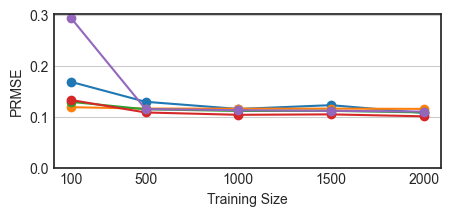

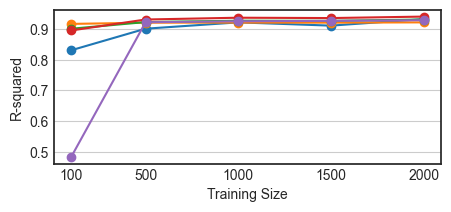

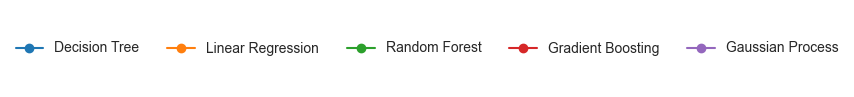

In [15]:
# Subplot 1: RMSE
plt.figure(figsize=(5, 2))
lines = []
labels = []

for name, scores in all_prmse_scores.items():
    line, = plt.plot(train_size, scores, marker='o', label=name)
    lines.append(line)
    labels.append(name)

plt.xlabel('Training Size')
plt.xticks(train_size, x_labels)
plt.ylabel('PRMSE')
plt.ylim(bottom=0)
plt.grid(True, axis='y')

plt.savefig('plots/rq2/rq2_rmse_selector.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Subplot 2: R-squared
plt.figure(figsize=(5, 2))
for name, scores in all_r2_scores.items():
    plt.plot(train_size, scores, marker='o', label=name)

plt.xlabel('Training Size')
plt.xticks(train_size, x_labels)
plt.ylabel('R-squared')
plt.grid(True, axis='y')

plt.savefig('plots/rq2/rq2_rsquared_selector.pdf', dpi=300, bbox_inches='tight')
plt.show()

fig_legend = plt.figure(figsize=(6, 1))
fig_legend.legend(
    handles=lines,
    labels=labels,
    loc='center',
    ncol=len(labels),
    frameon=False
)

plt.axis('off')
plt.savefig('plots/rq2/rq2_selector_legend.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
folders = ['vm/new/3high-3low/0iid', 'vm/new/3high-3low/100iid',
           'vm/new/5high-5low/0iid', 'vm/new/5high-5low/100iid',
           'vm/new/10high-10low/0iid', 'vm/new/10high-10low/100iid',
           'vm/new/4high-2low/0iid', 'vm/new/4high-2low/100iid',
           'vm/new/8high-4low/0iid', 'vm/new/8high-4low/100iid',
           'vm/new/2high-4low/0iid', 'vm/new/2high-4low/100iid',
           'vm/new/4high-8low/0iid', 'vm/new/4high-8low/100iid',
           'vm/new/2high-8low/0iid', 'vm/new/2high-8low/100iid']

selected_confs = ['no-selector-text', 'random-selector-text']
exp_data_selector: pd.DataFrame = pd.DataFrame()

for folder in folders:
    experiments = [subfolder for subfolder in os.listdir(os.getcwd() + '/' + folder)]
    for exp in experiments:
        exp_path = os.getcwd() + '/' + folder + '/' + exp
        if exp_path.split('/')[-1].split('_')[0] not in selected_confs:
            continue
        if 'FLwithAP_performance_metrics.csv' in os.listdir(exp_path):
            df = pd.read_csv(exp_path + '/FLwithAP_performance_metrics.csv')
            df['Exp Name'] = exp_path.split('/')[-1]
            df['F1/Time'] = df['Val F1'] / df['Total Time of FL Round']
            df['N. Clients'] = df.apply(lambda x: x['Client ID'].split('Client ')[1].split('\n')[0], axis=1)
            last_client = [int(x) for x in df['N. Clients'].unique()]
            df['High-Spec Clients'] = int(folder.split('/')[2].split('high-')[0])
            df['Low-Spec Clients'] = int(folder.split('/')[2].split('high-')[1].split('low')[0])
            df = df[df['Val F1'] >= 0]
            df['Previous Val F1'] = df.shift(1)['Val F1']
            df['Previous F1/Time'] = df.shift(1)['F1/Time']
            df['IID Data'] = int(folder.split('/')[-1].split('iid')[0])
            df = df[df['FL Round'] > 1]

            # determines whether selector was activated for the round
            df['Selector'] = df['N. Clients'].apply(lambda n: int(n) != max(last_client))

            df = df[['Exp Name', 'N. Clients', 'High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'FL Round',
                     'Selector', 'Total Time of FL Round', 'Previous F1/Time', 'Previous Val F1', 'F1/Time', 'Val F1']]
            exp_data_selector = pd.concat([exp_data_selector, df])

print(exp_data_selector.sample(n=100, random_state=42)['Total Time of FL Round'].sum())

In [ ]:
x = exp_data_selector[['High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'Selector', 'Previous F1/Time']]
y = exp_data_selector[['F1/Time']]

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

# --- Regressors to Compare ---
regressors = {
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=42),
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Gaussian Process": GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
}

samples = [100, 500, 1000, 1500, 2000]
train_size = [x / len(exp_data_selector) for x in samples]
x_labels = []

# Dictionaries to store scores for each regressor
all_rmse_scores = {name: [] for name in regressors.keys()}
all_prmse_scores = {name: [] for name in regressors.keys()}
all_r2_scores = {name: [] for name in regressors.keys()}

# --- Main Loop to Evaluate Regressors ---
for size in train_size:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=(1 - size), random_state=42)
    x_labels.append(str(len(x_train)))
    # Calculate the mean of the actual Y values in the TEST set
    # This is crucial for percentage calculation relevant to the test set performance
    mean_y_test = y_test['F1/Time'].mean()

    for name, regressor_model in regressors.items():
        regressor_model.fit(x_train, y_train.values.ravel())  # .values.ravel() for single-column y

        y_pred = regressor_model.predict(x_test)

        # Calculate RMSE
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        all_rmse_scores[name].append(rmse)

        # Calculate Percentage RMSE (PRMSE)
        if mean_y_test != 0:  # Avoid division by zero
            prmse = (rmse / mean_y_test)
        else:
            prmse = np.nan  # Or handle as appropriate if mean_y_test can be zero
        all_prmse_scores[name].append(prmse)

        # Calculate R-squared
        r2 = r2_score(y_test, y_pred)
        all_r2_scores[name].append(r2)

# Subplot 1: RMSE
plt.figure(figsize=(5, 2))
for name, scores in all_prmse_scores.items():
    plt.plot(train_size, scores, marker='o', label=name)
plt.xlabel('Training Size')
plt.xticks(train_size, x_labels)
plt.ylabel('PRMSE')
plt.ylim(bottom=0)
# plt.legend()
plt.grid(True, axis='y')
plt.savefig('plots/rq2/rq2_rmse_selector-text.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Subplot 2: R-squared
plt.figure(figsize=(5, 2))
for name, scores in all_r2_scores.items():
    plt.plot(train_size, scores, marker='o', label=name)
plt.xlabel('Training Size')
plt.xticks(train_size, x_labels)
plt.ylabel('R-squared')
# plt.legend()
plt.grid(True, axis='y')

plt.savefig('plots/rq2/rq2_rsquared_selector-text.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
folders = ['vm/new/3high-3low/0iid', 'vm/new/4high-8low/0iid',
           'vm/new/5high-5low/0iid', 'vm/new/2high-8low/0iid',
           'vm/new/4high-2low/0iid', 'vm/new/8high-4low/0iid',
           'vm/new/2high-4low/0iid']
selected_confs = ['no-hdh', 'random-hdh', 'always-hdh']
exp_data_hdh: pd.DataFrame = pd.DataFrame()


def shift_row(row, col_to_shift, shift_col, dataframe):
    return dataframe[col_to_shift].shift(row[shift_col])[row.name]


for folder in folders:
    experiments = [subfolder for subfolder in os.listdir(os.getcwd() + '/' + folder)]
    for exp in experiments:
        exp_path = os.getcwd() + '/' + folder + '/' + exp
        exp_name = exp_path.split('/')[-1].split('_')[0]
        if exp_name not in selected_confs:
            continue
        if 'FLwithAP_performance_metrics.csv' in os.listdir(exp_path):
            df = pd.read_csv(exp_path + '/FLwithAP_performance_metrics.csv')
            df['Exp Name'] = exp_path.split('/')[-1]
            df['F1/Time'] = df['Val F1'] / df['Total Time of FL Round']
            df['Client ID'] = df.apply(lambda x: int(x['Client ID'].split('Client ')[1].split('\n')[0]), axis=1)
            last_client = max([int(x) for x in df['Client ID'].unique()])
            high_spec_clients = int(folder.split('/')[2].split('high-')[0])
            low_spec_clients = int(folder.split('/')[2].split('high-')[1].split('low')[0])
            df['High-Spec Clients'] = high_spec_clients
            df['Low-Spec Clients'] = low_spec_clients
            df['IID Data'] = int(folder.split('/')[-1].split('iid')[0])

            df['Previous JSD'] = df.shift(high_spec_clients + low_spec_clients)['JSD']

            df['HDH'] = df.apply(lambda x: x['HDH Time'] > 0.0, axis=1)
            df['shift_by'] = df.apply(lambda x: x['Client ID'] - last_client, axis=1)
            df['Filled F1/Time'] = df.apply(lambda row: shift_row(row, "F1/Time", "shift_by", df), axis=1)
            df['Filled F1'] = df.apply(lambda row: shift_row(row, "Val F1", "shift_by", df), axis=1)

            df['Previous Val F1'] = df.shift(high_spec_clients + low_spec_clients)['Filled F1']
            df['Previous F1/Time'] = df.shift(high_spec_clients + low_spec_clients)['Filled F1/Time']

            df['Final F1/Time'] = df["F1/Time"].iloc[-1]
            df['Final F1'] = df["Val F1"].iloc[-1]

            df = df[df['FL Round'] > 1]

            df = df[['Exp Name', 'Client ID', 'High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'FL Round',
                     'HDH', 'Total Time of FL Round', 'JSD', 'Previous JSD', 'F1/Time', 'Val F1',
                     'Previous Val F1', 'Previous F1/Time',
                     'Filled F1', 'Filled F1/Time', 'Final F1/Time', 'Final F1']]
            exp_data_hdh = pd.concat([exp_data_hdh, df])

print(exp_data_hdh)

In [ ]:
x = exp_data_hdh[['FL Round', 'HDH', 'Previous JSD', 'Previous Val F1']]
y = exp_data_hdh[['Filled F1']]

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
random_state = 1997

# --- Regressors to Compare ---
regressors = {
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=random_state),
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=random_state, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=random_state),
    "Gaussian Process": GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=random_state)
}

samples = [100, 500.5, 1000, 1500, 2000]
train_size = [x / len(exp_data_hdh) for x in samples]

# Dictionaries to store scores for each regressor
all_rmse_scores = {name: [] for name in regressors.keys()}
all_prmse_scores = {name: [] for name in regressors.keys()}
all_r2_scores = {name: [] for name in regressors.keys()}

x_labels = []

# --- Main Loop to Evaluate Regressors ---
for size in train_size:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=(1 - size), random_state=42)
    x_labels.append(str(len(x_train)))
    # Calculate the mean of the actual Y values in the TEST set
    # This is crucial for percentage calculation relevant to the test set performance
    mean_y_test = y_test['Filled F1'].mean()

    for name, regressor_model in regressors.items():
        regressor_model.fit(x_train, y_train.values.ravel())  # .values.ravel() for single-column y

        y_pred = regressor_model.predict(x_test)

        # Calculate RMSE
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        all_rmse_scores[name].append(rmse)

        # Calculate Percentage RMSE (PRMSE)
        if mean_y_test != 0:  # Avoid division by zero
            prmse = (rmse / mean_y_test)
        else:
            prmse = np.nan  # Or handle as appropriate if mean_y_test can be zero
        all_prmse_scores[name].append(prmse)

        # Calculate R-squared
        r2 = r2_score(y_test, y_pred)
        all_r2_scores[name].append(r2)

# Subplot 1: RMSE
plt.style.use('seaborn-v0_8-white')
plt.figure(figsize=(5, 2))
for name, scores in all_prmse_scores.items():
    plt.plot(train_size, scores, marker='o', label=name)
plt.xlabel('Training Size')
plt.xticks(train_size, x_labels)
plt.ylabel('PRMSE')
plt.ylim(bottom=0)
# plt.legend()
plt.grid(True, axis='y')
plt.savefig('plots/rq2/rq2_rmse_hdh.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Subplot 2: R-squared
plt.figure(figsize=(5, 2))
for name, scores in all_r2_scores.items():
    plt.plot(train_size, scores, marker='o', label=name)
plt.xlabel('Training Size')
plt.xticks(train_size, x_labels)
plt.ylabel('R-squared')
# plt.legend()
plt.grid(True, axis='y')

plt.savefig('plots/rq2/rq2_rsquared_hdh.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
folders = ['vm/new/3high-3low/0iid', 'vm/new/4high-8low/0iid',
           'vm/new/5high-5low/0iid', 'vm/new/2high-8low/0iid',
           'vm/new/4high-2low/0iid', 'vm/new/8high-4low/0iid',
           'vm/new/2high-4low/0iid']
selected_confs = ['no-hdh-text', 'random-hdh-text', 'always-hdh-text']
exp_data_hdh: pd.DataFrame = pd.DataFrame()


def shift_row(row, col_to_shift, shift_col, dataframe):
    return dataframe[col_to_shift].shift(row[shift_col])[row.name]


for folder in folders:
    experiments = [subfolder for subfolder in os.listdir(os.getcwd() + '/' + folder)]
    for exp in experiments:
        exp_path = os.getcwd() + '/' + folder + '/' + exp
        exp_name = exp_path.split('/')[-1].split('_')[0]
        if exp_name not in selected_confs:
            continue
        if 'FLwithAP_performance_metrics.csv' in os.listdir(exp_path):
            df = pd.read_csv(exp_path + '/FLwithAP_performance_metrics.csv')
            df['Exp Name'] = exp_path.split('/')[-1]
            df['F1/Time'] = df['Val F1'] / df['Total Time of FL Round']
            df['Client ID'] = df.apply(lambda x: int(x['Client ID'].split('Client ')[1].split('\n')[0]), axis=1)
            last_client = max([int(x) for x in df['Client ID'].unique()])
            high_spec_clients = int(folder.split('/')[2].split('high-')[0])
            low_spec_clients = int(folder.split('/')[2].split('high-')[1].split('low')[0])
            df['High-Spec Clients'] = high_spec_clients
            df['Low-Spec Clients'] = low_spec_clients
            df['IID Data'] = int(folder.split('/')[-1].split('iid')[0])

            df['Previous JSD'] = df.shift(high_spec_clients + low_spec_clients)['JSD']

            df['HDH'] = df.apply(lambda x: x['HDH Time'] > 0.0, axis=1)
            df['shift_by'] = df.apply(lambda x: x['Client ID'] - last_client, axis=1)
            df['Filled F1/Time'] = df.apply(lambda row: shift_row(row, "F1/Time", "shift_by", df), axis=1)
            df['Filled F1'] = df.apply(lambda row: shift_row(row, "Val F1", "shift_by", df), axis=1)

            df['Previous Val F1'] = df.shift(high_spec_clients + low_spec_clients)['Filled F1']
            df['Previous F1/Time'] = df.shift(high_spec_clients + low_spec_clients)['Filled F1/Time']

            df['Final F1/Time'] = df["F1/Time"].iloc[-1]
            df['Final F1'] = df["Val F1"].iloc[-1]

            df = df[df['FL Round'] > 1]

            df = df[['Exp Name', 'Client ID', 'High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'FL Round',
                     'HDH', 'Total Time of FL Round', 'JSD', 'Previous JSD', 'F1/Time', 'Val F1',
                     'Previous Val F1', 'Previous F1/Time',
                     'Filled F1', 'Filled F1/Time', 'Final F1/Time', 'Final F1']]
            exp_data_hdh = pd.concat([exp_data_hdh, df])

print(exp_data_hdh)

In [ ]:
x = exp_data_hdh[['FL Round', 'HDH', 'Previous JSD', 'Previous Val F1']]
y = exp_data_hdh[['Filled F1']]

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
random_state = 1997

# --- Regressors to Compare ---
regressors = {
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=random_state),
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=random_state, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=random_state),
    "Gaussian Process": GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=random_state)
}

samples = [100, 500.5, 1000, 1500, 2000]
train_size = [x / len(exp_data_hdh) for x in samples]

# Dictionaries to store scores for each regressor
all_rmse_scores = {name: [] for name in regressors.keys()}
all_prmse_scores = {name: [] for name in regressors.keys()}
all_r2_scores = {name: [] for name in regressors.keys()}

x_labels = []

# --- Main Loop to Evaluate Regressors ---
for size in train_size:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=(1 - size), random_state=42)
    x_labels.append(str(len(x_train)))
    # Calculate the mean of the actual Y values in the TEST set
    # This is crucial for percentage calculation relevant to the test set performance
    mean_y_test = y_test['Filled F1'].mean()

    for name, regressor_model in regressors.items():
        regressor_model.fit(x_train, y_train.values.ravel())  # .values.ravel() for single-column y

        y_pred = regressor_model.predict(x_test)

        # Calculate RMSE
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        all_rmse_scores[name].append(rmse)

        # Calculate Percentage RMSE (PRMSE)
        if mean_y_test != 0:  # Avoid division by zero
            prmse = (rmse / mean_y_test)
        else:
            prmse = np.nan  # Or handle as appropriate if mean_y_test can be zero
        all_prmse_scores[name].append(prmse)

        # Calculate R-squared
        r2 = r2_score(y_test, y_pred)
        all_r2_scores[name].append(r2)

# Subplot 1: RMSE
plt.style.use('seaborn-v0_8-white')
plt.figure(figsize=(5, 2))
for name, scores in all_prmse_scores.items():
    plt.plot(train_size, scores, marker='o', label=name)
plt.xlabel('Training Size')
plt.xticks(train_size, x_labels)
plt.ylabel('PRMSE')
plt.ylim(bottom=0)
# plt.legend()
plt.grid(True, axis='y')
plt.savefig('plots/rq2/rq2_rmse_hdh-text.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Subplot 2: R-squared
plt.figure(figsize=(5, 2))
for name, scores in all_r2_scores.items():
    plt.plot(train_size, scores, marker='o', label=name)
plt.xlabel('Training Size')
plt.xticks(train_size, x_labels)
plt.ylabel('R-squared')
# plt.legend()
plt.grid(True, axis='y')

plt.savefig('plots/rq2/rq2_rsquared_hdh-text.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
folders = ['vm/same/3high-3low/0iid', 'vm/same/3high-3low/100iid',
           'vm/same/5high-5low/0iid', 'vm/same/5high-5low/100iid',
           'vm/same/4high-2low/0iid', 'vm/same/4high-2low/100iid',
           'vm/same/2high-4low/0iid', 'vm/same/2high-4low/100iid', ]
selected_confs = ['always-compressor', 'no-compressor', 'always-compressor-delay', 'no-compressor-delay']
exp_data_compressor: pd.DataFrame = pd.DataFrame()


def shift_row(row, col_to_shift, shift_col, dataframe):
    return dataframe[col_to_shift].shift(row[shift_col])[row.name]


for folder in folders:
    experiments = [subfolder for subfolder in os.listdir(os.getcwd() + '/' + folder)]
    for exp in experiments:
        exp_path = os.getcwd() + '/' + folder + '/' + exp
        exp_name = exp_path.split('/')[-1].split('_')[0]
        if exp_name not in selected_confs:
            continue
        if 'FLwithAP_performance_metrics.csv' in os.listdir(exp_path):
            df = pd.read_csv(exp_path + '/FLwithAP_performance_metrics.csv')
            df['Exp Name'] = exp_path.split('/')[-1]
            df['F1/Time'] = df['Val F1'] / df['Total Time of FL Round']
            df['Client ID'] = df.apply(lambda x: int(x['Client ID'].split('Client ')[1].split('\n')[0]), axis=1)
            last_client = max([int(x) for x in df['Client ID'].unique()])
            high_spec_clients = int(folder.split('/')[2].split('high-')[0])
            low_spec_clients = int(folder.split('/')[2].split('high-')[1].split('low')[0])
            df['High-Spec Clients'] = high_spec_clients
            df['Low-Spec Clients'] = low_spec_clients
            df['IID Data'] = int(folder.split('/')[-1].split('iid')[0])

            df['Compressor'] = exp_name.split('-')[0] == 'always'

            df['shift_by'] = df.apply(lambda x: x['Client ID'] - last_client, axis=1)
            df['Filled F1/Time'] = df.apply(lambda row: shift_row(row, "F1/Time", "shift_by", df), axis=1)
            df['Filled F1'] = df.apply(lambda row: shift_row(row, "Val F1", "shift_by", df), axis=1)
            df['Filled Total Time'] = df.apply(lambda row: shift_row(row, "Total Time of FL Round", "shift_by", df),
                                               axis=1)

            df['Previous Communication Time'] = df.shift(high_spec_clients + low_spec_clients)['Communication Time']
            df['Previous Val F1'] = df.shift(high_spec_clients + low_spec_clients)['Filled F1']
            df['Previous Total Time'] = df.shift(high_spec_clients + low_spec_clients)['Filled Total Time']
            df['Previous F1/Time'] = df.shift(high_spec_clients + low_spec_clients)['Filled F1/Time']

            df['Final F1/Time'] = df["F1/Time"].iloc[-1]
            df['Final F1'] = df["Val F1"].iloc[-1]

            df = df[df['FL Round'] > 1]

            df = df[['Exp Name', 'Client ID', 'High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'FL Round',
                     'Total Time of FL Round', 'F1/Time', 'Previous Total Time', 'Compressor',
                     'Previous Communication Time', 'Filled Total Time',
                     'Communication Time', 'Filled F1/Time', 'Final F1/Time']]
            exp_data_compressor = pd.concat([exp_data_compressor, df])

print(exp_data_compressor.sample(n=1000, random_state=42)['Total Time of FL Round'].sum())

In [ ]:
x = exp_data_compressor[['High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'Compressor', 'Previous Total Time']]
y = exp_data_compressor[['Filled Total Time']]

# --- Regressors to Compare ---
regressors = {
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Gaussian Process": GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=random_state)
}

samples = [100, 500, 1000, 1500, 2000]
train_size = [x / len(exp_data_compressor) for x in samples]

# Dictionaries to store scores for each regressor
all_rmse_scores = {name: [] for name in regressors.keys()}
all_prmse_scores = {name: [] for name in regressors.keys()}
all_r2_scores = {name: [] for name in regressors.keys()}

x_labels = []

# --- Main Loop to Evaluate Regressors ---
for size in train_size:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=(1 - size), random_state=42)
    x_labels.append(str(len(x_train)))
    # Calculate the mean of the actual Y values in the TEST set
    # This is crucial for percentage calculation relevant to the test set performance
    mean_y_test = y_test['Filled Total Time'].mean()

    for name, regressor_model in regressors.items():
        regressor_model.fit(x_train, y_train.values.ravel())  # .values.ravel() for single-column y

        y_pred = regressor_model.predict(x_test)

        # Calculate RMSE
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        all_rmse_scores[name].append(rmse)

        # Calculate Percentage RMSE (PRMSE)
        if mean_y_test != 0:  # Avoid division by zero
            prmse = (rmse / mean_y_test)
        else:
            prmse = np.nan  # Or handle as appropriate if mean_y_test can be zero
        all_prmse_scores[name].append(prmse)

        # Calculate R-squared
        r2 = r2_score(y_test, y_pred)
        all_r2_scores[name].append(r2)

# Subplot 1: RMSE
plt.style.use('seaborn-v0_8-white')
plt.figure(figsize=(5, 2))
for name, scores in all_prmse_scores.items():
    plt.plot(train_size, scores, marker='o', label=name)
plt.xlabel('Training Size')
plt.xticks(train_size, x_labels)
plt.ylabel('PRMSE')
plt.ylim(bottom=0)
# plt.legend()
plt.grid(True, axis='y')
plt.savefig('plots/rq2/rq2_rmse_compressor.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Subplot 2: R-squared
plt.figure(figsize=(5, 2))
for name, scores in all_r2_scores.items():
    plt.plot(train_size, scores, marker='o', label=name)
plt.xlabel('Training Size')
plt.xticks(train_size, x_labels)
plt.ylabel('R-squared')
# plt.legend()
plt.grid(True, axis='y')

plt.savefig('plots/rq2/rq2_rsquared_compressor.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
folders = ['vm/same/2high-4low/0iid', 'vm/same/2high-8low/100iid',
           'vm/same/3high-3low/0iid', 'vm/same/4high-2low/100iid',
           'vm/same/4high-8low/0iid', 'vm/same/5high-5low/100iid',
           'vm/same/8high-4low/0iid', 'vm/same/10high-10low/100iid', ]
selected_confs = ['always-compressor-text', 'no-compressor-text', 'always-compressor-text-delay',
                  'no-compressor-text-delay']
exp_data_compressor: pd.DataFrame = pd.DataFrame()


def shift_row(row, col_to_shift, shift_col, dataframe):
    return dataframe[col_to_shift].shift(row[shift_col])[row.name]


for folder in folders:
    experiments = [subfolder for subfolder in os.listdir(os.getcwd() + '/' + folder)]
    for exp in experiments:
        exp_path = os.getcwd() + '/' + folder + '/' + exp
        exp_name = exp_path.split('/')[-1].split('_')[0]
        if exp_name not in selected_confs:
            continue
        if 'FLwithAP_performance_metrics.csv' in os.listdir(exp_path):
            df = pd.read_csv(exp_path + '/FLwithAP_performance_metrics.csv')
            df['Exp Name'] = exp_path.split('/')[-1]
            df['F1/Time'] = df['Val F1'] / df['Total Time of FL Round']
            df['Client ID'] = df.apply(lambda x: int(x['Client ID'].split('Client ')[1].split('\n')[0]), axis=1)
            last_client = max([int(x) for x in df['Client ID'].unique()])
            high_spec_clients = int(folder.split('/')[2].split('high-')[0])
            low_spec_clients = int(folder.split('/')[2].split('high-')[1].split('low')[0])
            df['High-Spec Clients'] = high_spec_clients
            df['Low-Spec Clients'] = low_spec_clients
            df['IID Data'] = int(folder.split('/')[-1].split('iid')[0])

            df['Compressor'] = exp_name.split('-')[0] == 'always'

            df['shift_by'] = df.apply(lambda x: x['Client ID'] - last_client, axis=1)
            df['Filled F1/Time'] = df.apply(lambda row: shift_row(row, "F1/Time", "shift_by", df), axis=1)
            df['Filled F1'] = df.apply(lambda row: shift_row(row, "Val F1", "shift_by", df), axis=1)
            df['Filled Total Time'] = df.apply(lambda row: shift_row(row, "Total Time of FL Round", "shift_by", df),
                                               axis=1)

            df['Previous Communication Time'] = df.shift(high_spec_clients + low_spec_clients)['Communication Time']
            df['Previous Val F1'] = df.shift(high_spec_clients + low_spec_clients)['Filled F1']
            df['Previous Total Time'] = df.shift(high_spec_clients + low_spec_clients)['Filled Total Time']
            df['Previous F1/Time'] = df.shift(high_spec_clients + low_spec_clients)['Filled F1/Time']

            df['Final F1/Time'] = df["F1/Time"].iloc[-1]
            df['Final F1'] = df["Val F1"].iloc[-1]

            df = df[df['FL Round'] > 1]

            df = df[['Exp Name', 'Client ID', 'High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'FL Round',
                     'Total Time of FL Round', 'F1/Time', 'Previous Total Time', 'Compressor',
                     'Previous Communication Time', 'Filled Total Time',
                     'Communication Time', 'Filled F1/Time', 'Final F1/Time']]
            exp_data_compressor = pd.concat([exp_data_compressor, df])

print(exp_data_compressor.sample(n=1000, random_state=42)['Total Time of FL Round'].sum())

In [ ]:
x = exp_data_compressor[['High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'Compressor', 'Previous Total Time']]
y = exp_data_compressor[['Filled Total Time']]

# --- Regressors to Compare ---
regressors = {
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Gaussian Process": GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=random_state)
}

samples = [100, 500, 1000, 1500, 2000]
train_size = [x / len(exp_data_compressor) for x in samples]

# Dictionaries to store scores for each regressor
all_rmse_scores = {name: [] for name in regressors.keys()}
all_prmse_scores = {name: [] for name in regressors.keys()}
all_r2_scores = {name: [] for name in regressors.keys()}

x_labels = []

# --- Main Loop to Evaluate Regressors ---
for size in train_size:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=(1 - size), random_state=42)
    x_labels.append(str(len(x_train)))
    # Calculate the mean of the actual Y values in the TEST set
    # This is crucial for percentage calculation relevant to the test set performance
    mean_y_test = y_test['Filled Total Time'].mean()

    for name, regressor_model in regressors.items():
        regressor_model.fit(x_train, y_train.values.ravel())  # .values.ravel() for single-column y

        y_pred = regressor_model.predict(x_test)

        # Calculate RMSE
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        all_rmse_scores[name].append(rmse)

        # Calculate Percentage RMSE (PRMSE)
        if mean_y_test != 0:  # Avoid division by zero
            prmse = (rmse / mean_y_test)
        else:
            prmse = np.nan  # Or handle as appropriate if mean_y_test can be zero
        all_prmse_scores[name].append(prmse)

        # Calculate R-squared
        r2 = r2_score(y_test, y_pred)
        all_r2_scores[name].append(r2)

# Subplot 1: RMSE
plt.style.use('seaborn-v0_8-white')
plt.figure(figsize=(5, 2))
for name, scores in all_prmse_scores.items():
    plt.plot(train_size, scores, marker='o', label=name)
plt.xlabel('Training Size')
plt.xticks(train_size, x_labels)
plt.ylabel('PRMSE')
plt.ylim(bottom=0)
# plt.legend()
plt.grid(True, axis='y')
plt.savefig('plots/rq2/rq2_rmse_compressor-text.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Subplot 2: R-squared
plt.figure(figsize=(5, 2))
for name, scores in all_r2_scores.items():
    plt.plot(train_size, scores, marker='o', label=name)
plt.xlabel('Training Size')
plt.xticks(train_size, x_labels)
plt.ylabel('R-squared')
# plt.legend()
plt.grid(True, axis='y')

plt.savefig('plots/rq2/rq2_rsquared_compressor-text.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [2]:
folders = ['vm/same/2high-4low/0iid', 'vm/new/2high-4low/0iid',
           'vm/same/3high-3low/0iid', 'vm/new/3high-3low/0iid',
           'vm/same/4high-2low/0iid', 'vm/new/4high-2low/0iid',
           'vm/same/2high-4low/100iid', 'vm/new/2high-4low/100iid',
           'vm/same/3high-3low/100iid', 'vm/new/3high-3low/100iid',
           'vm/same/4high-2low/100iid', 'vm/new/4high-2low/100iid']

selected_confs = ['no-selector-2', 'random-selector-2']
exp_data_selector: pd.DataFrame = pd.DataFrame()

for folder in folders:
    experiments = [subfolder for subfolder in os.listdir(os.getcwd() + '/' + folder)]
    for exp in experiments:
        exp_path = os.getcwd() + '/' + folder + '/' + exp
        if exp_path.split('/')[-1].split('_')[0] not in selected_confs:
            continue
        if 'FLwithAP_performance_metrics.csv' in os.listdir(exp_path):
            df = pd.read_csv(exp_path + '/FLwithAP_performance_metrics.csv')
            df['Exp Name'] = exp_path.split('/')[-1]
            df['F1/Time'] = df['Val F1'] / df['Total Time of FL Round']
            df['N. Clients'] = df.apply(lambda x: x['Client ID'].split('Client ')[1].split('\n')[0], axis=1)
            last_client = [int(x) for x in df['N. Clients'].unique()]
            df['High-Spec Clients'] = int(folder.split('/')[2].split('high-')[0])
            df['Low-Spec Clients'] = int(folder.split('/')[2].split('high-')[1].split('low')[0])
            df = df[df['Val F1'] >= 0]
            df['Previous Val F1'] = df.shift(1)['Val F1']
            df['Previous F1/Time'] = df.shift(1)['F1/Time']
            df['IID Data'] = int(folder.split('/')[-1].split('iid')[0])
            df = df[df['FL Round'] > 1]

            # determines whether selector was activated for the round
            df['Selector'] = df['N. Clients'].apply(lambda n: int(n) != max(last_client))

            df = df[['Exp Name', 'N. Clients', 'High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'FL Round',
                     'Selector', 'Total Time of FL Round', 'Previous F1/Time', 'Previous Val F1', 'F1/Time', 'Val F1']]
            exp_data_selector = pd.concat([exp_data_selector, df])

print(exp_data_selector.sample(n=100, random_state=42)['Total Time of FL Round'].sum())

9988.32


In [5]:
x = exp_data_selector[['High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'Selector', 'Previous F1/Time']]
y = exp_data_selector[['F1/Time']]

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

# --- Regressors to Compare ---
regressors = {
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=42),
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Gaussian Process": GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
}

samples = [100, 250, 500, 750, 1000]
train_size = [x / len(exp_data_selector) for x in samples]
x_labels = []

# Dictionaries to store scores for each regressor
all_rmse_scores = {name: [] for name in regressors.keys()}
all_prmse_scores = {name: [] for name in regressors.keys()}
all_r2_scores = {name: [] for name in regressors.keys()}

# --- Main Loop to Evaluate Regressors ---
for size in train_size:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=(1 - size), random_state=42)
    x_labels.append(str(len(x_train)))
    # Calculate the mean of the actual Y values in the TEST set
    # This is crucial for percentage calculation relevant to the test set performance
    mean_y_test = y_test['F1/Time'].mean()

    for name, regressor_model in regressors.items():
        regressor_model.fit(x_train, y_train.values.ravel())  # .values.ravel() for single-column y

        y_pred = regressor_model.predict(x_test)

        # Calculate RMSE
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        all_rmse_scores[name].append(rmse)

        # Calculate Percentage RMSE (PRMSE)
        if mean_y_test != 0:  # Avoid division by zero
            prmse = (rmse / mean_y_test)
        else:
            prmse = np.nan  # Or handle as appropriate if mean_y_test can be zero
        all_prmse_scores[name].append(prmse)

        # Calculate R-squared
        r2 = r2_score(y_test, y_pred)
        all_r2_scores[name].append(r2)


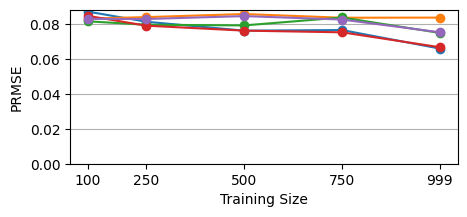

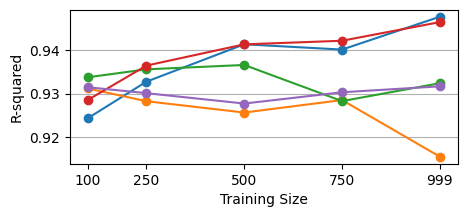

In [6]:
# Subplot 1: RMSE
plt.figure(figsize=(5, 2))
lines = []
labels = []

for name, scores in all_prmse_scores.items():
    line, = plt.plot(train_size, scores, marker='o', label=name)
    lines.append(line)
    labels.append(name)

plt.xlabel('Training Size')
plt.xticks(train_size, x_labels)
plt.ylabel('PRMSE')
plt.ylim(bottom=0)
plt.grid(True, axis='y')

plt.savefig('plots/rq2/rq2_rmse_selector-2.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Subplot 2: R-squared
plt.figure(figsize=(5, 2))
for name, scores in all_r2_scores.items():
    plt.plot(train_size, scores, marker='o', label=name)

plt.xlabel('Training Size')
plt.xticks(train_size, x_labels)
plt.ylabel('R-squared')
plt.grid(True, axis='y')

plt.savefig('plots/rq2/rq2_rsquared_selector-2.pdf', dpi=300, bbox_inches='tight')
plt.show()

fig_legend = plt.figure(figsize=(6, 1))
fig_legend.legend(
    handles=lines,
    labels=labels,
    loc='center',
    ncol=len(labels),
    frameon=False
)


In [7]:
folders = ['vm/same/2high-4low/0iid', 'vm/new/2high-4low/0iid',
           'vm/same/3high-3low/0iid', 'vm/new/3high-3low/0iid',
           'vm/same/4high-2low/0iid', 'vm/new/4high-2low/0iid',
           'vm/same/2high-4low/100iid', 'vm/new/2high-4low/100iid',
           'vm/same/3high-3low/100iid', 'vm/new/3high-3low/100iid',
           'vm/same/4high-2low/100iid', 'vm/new/4high-2low/100iid']
selected_confs = ['no-hdh-2', 'random-hdh-2', 'always-hdh-2']
exp_data_hdh: pd.DataFrame = pd.DataFrame()


def shift_row(row, col_to_shift, shift_col, dataframe):
    return dataframe[col_to_shift].shift(row[shift_col])[row.name]


for folder in folders:
    experiments = [subfolder for subfolder in os.listdir(os.getcwd() + '/' + folder)]
    for exp in experiments:
        exp_path = os.getcwd() + '/' + folder + '/' + exp
        exp_name = exp_path.split('/')[-1].split('_')[0]
        if exp_name not in selected_confs:
            continue
        if 'FLwithAP_performance_metrics.csv' in os.listdir(exp_path):
            df = pd.read_csv(exp_path + '/FLwithAP_performance_metrics.csv')
            df['Exp Name'] = exp_path.split('/')[-1]
            df['F1/Time'] = df['Val F1'] / df['Total Time of FL Round']
            df['Client ID'] = df.apply(lambda x: int(x['Client ID'].split('Client ')[1].split('\n')[0]), axis=1)
            last_client = max([int(x) for x in df['Client ID'].unique()])
            high_spec_clients = int(folder.split('/')[2].split('high-')[0])
            low_spec_clients = int(folder.split('/')[2].split('high-')[1].split('low')[0])
            df['High-Spec Clients'] = high_spec_clients
            df['Low-Spec Clients'] = low_spec_clients
            df['IID Data'] = int(folder.split('/')[-1].split('iid')[0])

            df['Previous JSD'] = df.shift(high_spec_clients + low_spec_clients)['JSD']

            df['HDH'] = df.apply(lambda x: x['HDH Time'] > 0.0, axis=1)
            df['shift_by'] = df.apply(lambda x: x['Client ID'] - last_client, axis=1)
            df['Filled F1/Time'] = df.apply(lambda row: shift_row(row, "F1/Time", "shift_by", df), axis=1)
            df['Filled F1'] = df.apply(lambda row: shift_row(row, "Val F1", "shift_by", df), axis=1)

            df['Previous Val F1'] = df.shift(high_spec_clients + low_spec_clients)['Filled F1']
            df['Previous F1/Time'] = df.shift(high_spec_clients + low_spec_clients)['Filled F1/Time']

            df['Final F1/Time'] = df["F1/Time"].iloc[-1]
            df['Final F1'] = df["Val F1"].iloc[-1]

            df = df[df['FL Round'] > 1]

            df = df[['Exp Name', 'Client ID', 'High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'FL Round',
                     'HDH', 'Total Time of FL Round', 'JSD', 'Previous JSD', 'F1/Time', 'Val F1',
                     'Previous Val F1', 'Previous F1/Time',
                     'Filled F1', 'Filled F1/Time', 'Final F1/Time', 'Final F1']]
            exp_data_hdh = pd.concat([exp_data_hdh, df])

print(exp_data_hdh)

           Exp Name  Client ID  High-Spec Clients  Low-Spec Clients  IID Data  \
6    always-hdh-2_1         23                  2                 4         0   
7    always-hdh-2_1         24                  2                 4         0   
8    always-hdh-2_1         25                  2                 4         0   
9    always-hdh-2_1         26                  2                 4         0   
10   always-hdh-2_1         27                  2                 4         0   
..              ...        ...                ...               ...       ...   
115  random-hdh-2_1         24                  4                 2         0   
116  random-hdh-2_1         25                  4                 2         0   
117  random-hdh-2_1         26                  4                 2         0   
118  random-hdh-2_1         27                  4                 2         0   
119  random-hdh-2_1         28                  4                 2         0   

     FL Round    HDH  Total

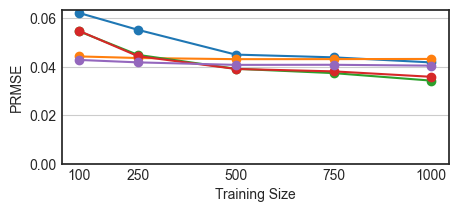

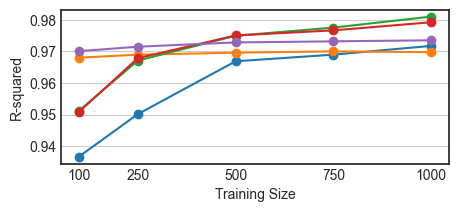

In [9]:
x = exp_data_hdh[['FL Round', 'HDH', 'Previous JSD', 'Previous Val F1']]
y = exp_data_hdh[['Filled F1']]

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
random_state = 1997

# --- Regressors to Compare ---
regressors = {
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=random_state),
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=random_state, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=random_state),
    "Gaussian Process": GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=random_state)
}

samples = [100, 250, 500, 750, 1000]
train_size = [x / len(exp_data_hdh) for x in samples]

# Dictionaries to store scores for each regressor
all_rmse_scores = {name: [] for name in regressors.keys()}
all_prmse_scores = {name: [] for name in regressors.keys()}
all_r2_scores = {name: [] for name in regressors.keys()}

x_labels = []

# --- Main Loop to Evaluate Regressors ---
for size in train_size:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=(1 - size), random_state=42)
    x_labels.append(str(len(x_train)))
    # Calculate the mean of the actual Y values in the TEST set
    # This is crucial for percentage calculation relevant to the test set performance
    mean_y_test = y_test['Filled F1'].mean()

    for name, regressor_model in regressors.items():
        regressor_model.fit(x_train, y_train.values.ravel())  # .values.ravel() for single-column y

        y_pred = regressor_model.predict(x_test)

        # Calculate RMSE
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        all_rmse_scores[name].append(rmse)

        # Calculate Percentage RMSE (PRMSE)
        if mean_y_test != 0:  # Avoid division by zero
            prmse = (rmse / mean_y_test)
        else:
            prmse = np.nan  # Or handle as appropriate if mean_y_test can be zero
        all_prmse_scores[name].append(prmse)

        # Calculate R-squared
        r2 = r2_score(y_test, y_pred)
        all_r2_scores[name].append(r2)

# Subplot 1: RMSE
plt.style.use('seaborn-v0_8-white')
plt.figure(figsize=(5, 2))
for name, scores in all_prmse_scores.items():
    plt.plot(train_size, scores, marker='o', label=name)
plt.xlabel('Training Size')
plt.xticks(train_size, x_labels)
plt.ylabel('PRMSE')
plt.ylim(bottom=0)
# plt.legend()
plt.grid(True, axis='y')
plt.savefig('plots/rq2/rq2_rmse_hdh-2.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Subplot 2: R-squared
plt.figure(figsize=(5, 2))
for name, scores in all_r2_scores.items():
    plt.plot(train_size, scores, marker='o', label=name)
plt.xlabel('Training Size')
plt.xticks(train_size, x_labels)
plt.ylabel('R-squared')
# plt.legend()
plt.grid(True, axis='y')

plt.savefig('plots/rq2/rq2_rsquared_hdh-2.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
folders = ['vm/same/2high-4low/0iid', 'vm/new/2high-4low/0iid',
           'vm/same/3high-3low/0iid', 'vm/new/3high-3low/0iid',
           'vm/same/4high-2low/0iid', 'vm/new/4high-2low/0iid',
           'vm/same/2high-4low/100iid', 'vm/new/2high-4low/100iid',
           'vm/same/3high-3low/100iid', 'vm/new/3high-3low/100iid',
           'vm/same/4high-2low/100iid', 'vm/new/4high-2low/100iid']
selected_confs = ['always-compressor-2', 'no-compressor-2', 'always-compressor-2-delay', 'no-compressor-2-delay']
exp_data_compressor: pd.DataFrame = pd.DataFrame()


def shift_row(row, col_to_shift, shift_col, dataframe):
    return dataframe[col_to_shift].shift(row[shift_col])[row.name]


for folder in folders:
    experiments = [subfolder for subfolder in os.listdir(os.getcwd() + '/' + folder)]
    for exp in experiments:
        exp_path = os.getcwd() + '/' + folder + '/' + exp
        exp_name = exp_path.split('/')[-1].split('_')[0]
        if exp_name not in selected_confs:
            continue
        if 'FLwithAP_performance_metrics.csv' in os.listdir(exp_path):
            df = pd.read_csv(exp_path + '/FLwithAP_performance_metrics.csv')
            df['Exp Name'] = exp_path.split('/')[-1]
            df['F1/Time'] = df['Val F1'] / df['Total Time of FL Round']
            df['Client ID'] = df.apply(lambda x: int(x['Client ID'].split('Client ')[1].split('\n')[0]), axis=1)
            last_client = max([int(x) for x in df['Client ID'].unique()])
            high_spec_clients = int(folder.split('/')[2].split('high-')[0])
            low_spec_clients = int(folder.split('/')[2].split('high-')[1].split('low')[0])
            df['High-Spec Clients'] = high_spec_clients
            df['Low-Spec Clients'] = low_spec_clients
            df['IID Data'] = int(folder.split('/')[-1].split('iid')[0])

            df['Compressor'] = exp_name.split('-')[0] == 'always'

            df['shift_by'] = df.apply(lambda x: x['Client ID'] - last_client, axis=1)
            df['Filled F1/Time'] = df.apply(lambda row: shift_row(row, "F1/Time", "shift_by", df), axis=1)
            df['Filled F1'] = df.apply(lambda row: shift_row(row, "Val F1", "shift_by", df), axis=1)
            df['Filled Total Time'] = df.apply(lambda row: shift_row(row, "Total Time of FL Round", "shift_by", df),
                                               axis=1)

            df['Previous Communication Time'] = df.shift(high_spec_clients + low_spec_clients)['Communication Time']
            df['Previous Val F1'] = df.shift(high_spec_clients + low_spec_clients)['Filled F1']
            df['Previous Total Time'] = df.shift(high_spec_clients + low_spec_clients)['Filled Total Time']
            df['Previous F1/Time'] = df.shift(high_spec_clients + low_spec_clients)['Filled F1/Time']

            df['Final F1/Time'] = df["F1/Time"].iloc[-1]
            df['Final F1'] = df["Val F1"].iloc[-1]

            df = df[df['FL Round'] > 1]

            df = df[['Exp Name', 'Client ID', 'High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'FL Round',
                     'Total Time of FL Round', 'F1/Time', 'Previous Total Time', 'Compressor',
                     'Previous Communication Time', 'Filled Total Time',
                     'Communication Time', 'Filled F1/Time', 'Final F1/Time']]
            exp_data_compressor = pd.concat([exp_data_compressor, df])

print(exp_data_compressor.sample(n=1000, random_state=42)['Total Time of FL Round'].sum())

16820.07


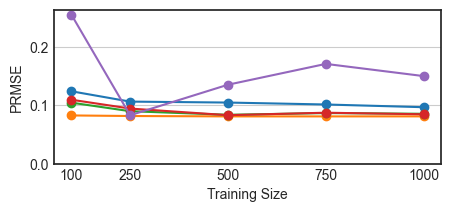

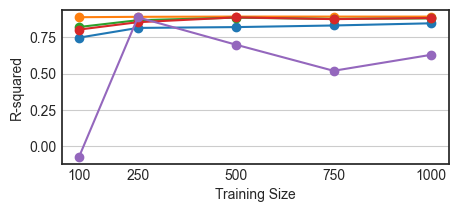

In [12]:
x = exp_data_compressor[['High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'Compressor', 'Previous Total Time']]
y = exp_data_compressor[['Filled Total Time']]

# --- Regressors to Compare ---
regressors = {
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Gaussian Process": GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=random_state)
}

samples = [100, 250, 500, 750, 1000]
train_size = [x / len(exp_data_compressor) for x in samples]

# Dictionaries to store scores for each regressor
all_rmse_scores = {name: [] for name in regressors.keys()}
all_prmse_scores = {name: [] for name in regressors.keys()}
all_r2_scores = {name: [] for name in regressors.keys()}

x_labels = []

# --- Main Loop to Evaluate Regressors ---
for size in train_size:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=(1 - size), random_state=26)
    x_labels.append(str(len(x_train)))
    # Calculate the mean of the actual Y values in the TEST set
    # This is crucial for percentage calculation relevant to the test set performance
    mean_y_test = y_test['Filled Total Time'].mean()

    for name, regressor_model in regressors.items():
        regressor_model.fit(x_train, y_train.values.ravel())  # .values.ravel() for single-column y

        y_pred = regressor_model.predict(x_test)

        # Calculate RMSE
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        all_rmse_scores[name].append(rmse)

        # Calculate Percentage RMSE (PRMSE)
        if mean_y_test != 0:  # Avoid division by zero
            prmse = (rmse / mean_y_test)
        else:
            prmse = np.nan  # Or handle as appropriate if mean_y_test can be zero
        all_prmse_scores[name].append(prmse)

        # Calculate R-squared
        r2 = r2_score(y_test, y_pred)
        all_r2_scores[name].append(r2)

# Subplot 1: RMSE
plt.style.use('seaborn-v0_8-white')
plt.figure(figsize=(5, 2))
for name, scores in all_prmse_scores.items():
    plt.plot(train_size, scores, marker='o', label=name)
plt.xlabel('Training Size')
plt.xticks(train_size, x_labels)
plt.ylabel('PRMSE')
plt.ylim(bottom=0)
# plt.legend()
plt.grid(True, axis='y')
plt.savefig('plots/rq2/rq2_rmse_compressor-2.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Subplot 2: R-squared
plt.figure(figsize=(5, 2))
for name, scores in all_r2_scores.items():
    plt.plot(train_size, scores, marker='o', label=name)
plt.xlabel('Training Size')
plt.xticks(train_size, x_labels)
plt.ylabel('R-squared')
# plt.legend()
plt.grid(True, axis='y')

plt.savefig('plots/rq2/rq2_rsquared_compressor-2.pdf', dpi=300, bbox_inches='tight')
plt.show()